# 10. 카메라 스티커앱 만들기 첫걸음

### 10-1. 카메라 스티커앱 만들기 첫걸음

##### 일단 한번 만들어보자!
____
스마트폰 시대에 모두가 가지고 있는 얼굴인식 카메라앱! 사용해보셨나요?

저도 부모님, 친구들, 연인과 함께 즐겁게 사용하고 있습니다. 컴퓨터비전 기술로 사람들에게 즐거움을 줄 수 있다는 사실은 언제나 열정을 샘솟게 하는 것 같습니다.

이번 코스에서는 얼굴인식 카메라앱을 따라 만들어 보겠습니다.

**이번 코스를 통해** 
1. 카메라앱 만들기를 통해 **동영상 처리**, **검출**, **키포인트 추정**, **추적**, **카메라 원근** 의 기술을 다룹니다.
2. 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있습니다.
___
이번 시간의 목표는 **"일단 한번 만들어 보자"** 입니다.

오늘은 직접 사진 한 장을 찍고 머리에 왕관 씌워 보는 것 까지 다루겠습니다.

이번 시간의 **목표**입니다.  
1. 얼굴인식 카메라의 흐름을 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리

오늘 사용할 왕관 이미지입니다.

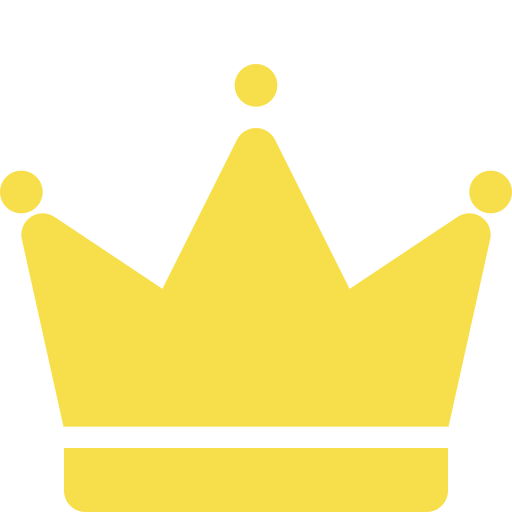

### 10-2. 어떻게 만들까? 사진 준비하기

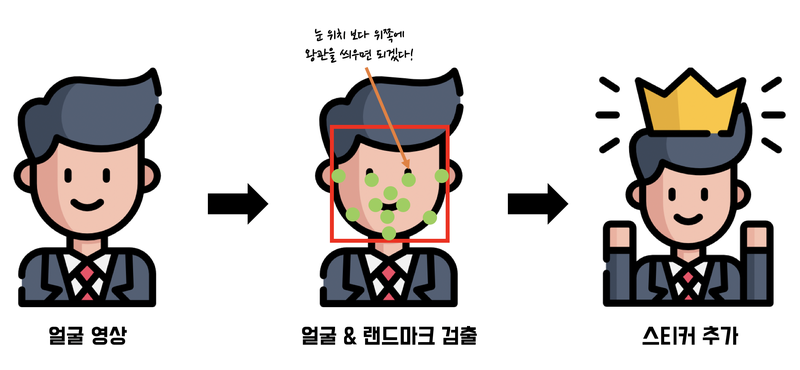


스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요합니다. 이 위치들을 찾아내는 기술을 랜드마크 landmark 또는 조정 alignment 이라고 합니다. 조금 더 큰 범위로는 keypoint detection 이라고 부르고 있습니다. 대부분의 face landmark 데이터셋은 눈, 코, 입과 턱을 포함하고 있습니다. 얼굴의 랜드마크를 찾아냈다면 머리의 위치를 예상하는 것은 쉽습니다. 눈과 코의 위치로부터 위로 떨어져 있는 정도를 데이터로부터 유추할 수 있을 겁니다.

따라서 우리는,  
1. 얼굴이 포함된 사진을 준비하고
2. 사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)
3. 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.

##### 사진을 준비하자
___
얼굴이 포함된 사진을 한 장 준비하겠습니다. 가지고 있는 카메라로 본인을 촬영하셔도 좋고 좋아하는 연예인이나 여자친구 사진도 좋습니다. 여자친구가 있는지 먼저 물어봐야 하는 거 아닌지 물어보신다면… 죄송합니다..

저는 제 사진을 사용하겠습니다. 준비하신 사진으로 교체해서 다음 단계를 따라와 주세요.

우선 다음과 같이 작업 디렉토리 구조를 세팅합니다.

```
mkdir -p ~/aiffel/camera_sticker/models
mkdir -p ~/aiffel/camera_sticker/images
```

사용할 디렉토리 구조는 아래와 같습니다. camera_sticker라는 작업 디렉토리 아래의 images 디렉토리에다가 image.jpg 으로 여러분만의 이미지를 저장해 주세요.

```
aiffel
├── camera_sticker
        └── models
        └── images
                └── image.jpg
```

여러분들의 이미지 뿐 아니라, 함께 활용할 왕관 이미지들도 미리 저장해 둡시다.

```
wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/king.png
wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/hero.png
mv king.png hero.png ~/aiffel/camera_sticker/images
```

아래는 오늘 활용해야 할 이미지 처리 관련 패키지들입니다. opencv, cmake, dlib 설치가 안 돼 있다면 터미널을 열어 아래와 같이 설치해 주세요. 👽

```
pip install opencv-python
pip install cmake
pip install dlib
```

설치에 다소 시간이 걸릴 수 있으니 마음의 여유를 가지고 기다려 주세요. ☕

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어옵니다.

준비한 이미지를 읽습니다.

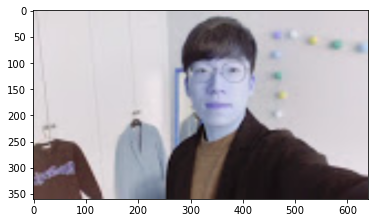

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

편의를 위해 이미지 크기를 변경합니다. 위에서는 640x360의 VGA 크기(16:9)로 고정했습니다. 이미지 가로 세로의 비율에 따라 알맞게 변경해주세요. 만약 종횡비(가로 세로 비율) 가 4:3이라면 640x480 으로 변경해주시면 됩니다.

그런데 좀 이상하지 않으신가요? 사진이 잘 나온것 같긴 한데 색상이 좀 이상합니다. 얼굴 색에 왜이렇게 푸른빛이 감도는 걸까요?
이것은 opencv의 특징 때문입니다. 오늘 사용하게 될 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용합니다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 그래서 여러분의 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것입니다. 그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해주게 됩니다.

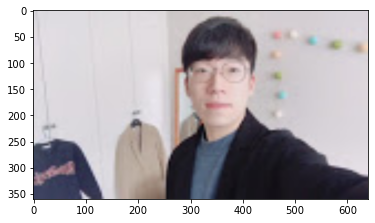

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

opencv는 아주 강력하고 방대한 기능을 갖춘 컴퓨터 비전 라이브러리입니다. 영상 관련 업계 표준 라이브러리의 지위를 가지고 있다고 할 수 있겠습니다. 아래 링크의 페이지를 방문해 봅시다. 어쩌면 앞으로도 자주 찾게 될지 모르겠군요. 한번 훑어본 후 아래 질문에 답변해 봅시다.

* 이미지 다루기 - [gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)

>Q1. cv2.imread('img.png', 0) 에서 0 은 무슨 의미일까요?   
A1. 문서에 따르면 이미지 읽기의 flag는 다음 3가지가 있습니다.   순서대로 1, 0, -1의 값을 갖습니다.   
cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.  
cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.  
cv2.imread('img.png', 0)이라고 호출했다면 이미지를 Grayscale로 읽어 들이겠다는 뜻입니다. 실제로 이미지 읽기 flag를 바꿔가면서 이미지가 어떻게 출력되는지 확인해 보세요.  

### 10-3. 얼굴 검출 face detection

Object detection 기술을 이용해서 얼굴의 위치를 찾겠습니다. 이번 시간에는 빠르게 만들기 위해 학습 없이 공개되어 있는 패키지를 사용하겠습니다.

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. HOG와 SVM의 자세한 알고리즘은 아래 링크를 참고해 주세요. (한국어 버전도 있습니다.)

* [딥러닝(Deep Learning)을 사용한 최신 얼굴 인식(Face Recognition) (한국어 번역본)](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)   
* [Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning (영어 원본)](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78)

위 링크의 글을 읽고 아래의 질문에 답해 봅시다.

>Q1. 이미지에서 그래디언트gradient를 특징feature으로 사용하는 이유는 무엇인가요?  
A1. 픽셀의 RGB값 자체보다는 인접한 픽셀들 사이의 색상 변화율 자체에 오브젝트의 특징이 더욱 정확히 반영될 때가 많기 때문이다. 예를 들어, 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르지만, 밝기가 변하는 방향(그래디언트)만 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다.  

>Q2. 단일 픽셀의 그래디언트를 사용하지 않고 16x16 의 정사각형을 이용하는 무엇일까요?  
A2. 단일 픽셀의 그래디언트만 다루면 너무 자세하여 나무만 보고 숲을 보지 못하게 될 수가 있다. 이미지의 기본 패턴을 알려면 픽셀보다는 높은 수준에서의 밝음/어둠의 기본 흐름을 보는 것이 더 좋기 때문이다.  

그럼 dlib을 활용해 hog detector를 선언해 보겠습니다.

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


detector를 이용해서 얼굴의 bounding box를 추출합니다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.

* [Image Pyramids - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)   

찾은 얼굴을 화면에 출력해보겠습니다.

rectangles[[(270, 64) (425, 219)]]


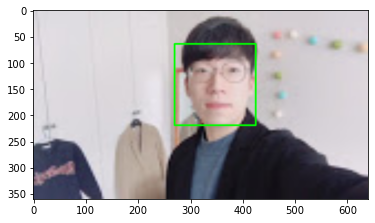

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 10-4. 얼굴 랜드마크 face landmark

앞서 말씀 드린 것처럼 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

**Object keypoint estimation 알고리즘**

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

##### Dlib landmark localization
___
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.
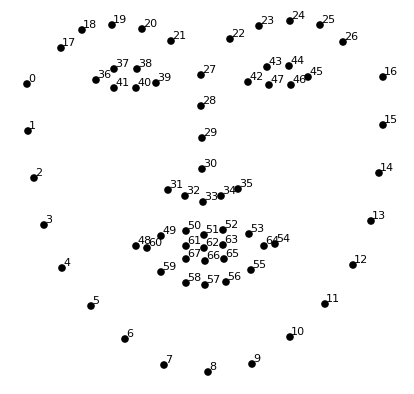

이 때 점의 개수는 데이터셋과 논문마다 다릅니다. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용합니다.
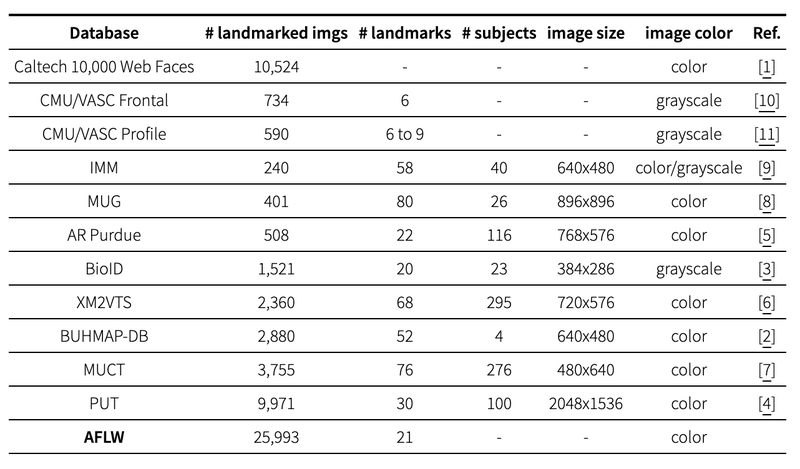

* [AFLW dataset](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/)   
Dlib은 ibug [300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)으로 학습한 pretrained model 을 제공합니다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용 했습니다. 자세한 내용이 궁금하신 분들은 2014년 CVPR (Computer Vision and Pattern Recognition) 에 발표한 논문One Millisecond Face Alignment with an Ensemble of Regression Trees 을 참고해 주세요. 오늘은 알고리즘을 이해하지 않아도 괜찮습니다.

* One Millisecond Face Alignment with an Ensemble of Regression Trees(http://www.nada.kth.se/~sullivan/Papers/Kazemi_cvpr14.pdf)  

Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 위치는 root 디렉토리의 models 디렉토리 입니다. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다.

```
wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
```

저장한 landmark 모델을 불러옵니다.

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


**points** 는 **dlib.full_object_detection** 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

랜드마크를 영상에 출력해 보겠습니다.

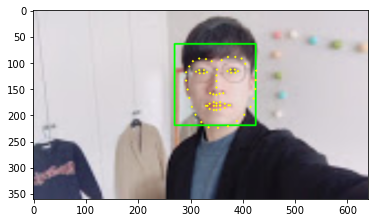

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

어떤가요? 아래그림과 같이 얼굴 랜드마크가 이미지에 정확히 출력되었나요?

### 10-5. 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었습니다.


랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.

1. 스티커 위치  
x = xnose   
y = ynose − width / 2

2. 스티커 크기  
width = height = widthbbox

좌표를 먼저 확인해 보겠습니다.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(350, 147)
(x,y) : (350,69)
(w,h) : (156,156)


제 얼굴 이미지에서는 코의 중심점이 (700, 291) 로 나오네요.

준비해 둔 스티커 이미지를 읽어서 적용해 보겠습니다.

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

In [12]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,-87)


출력해보면 문제가 생기는 것을 확인할 수 있습니다. y축 좌표의 값이 음수가 계산 되었습니다.

음수는 무슨 의미일까요?

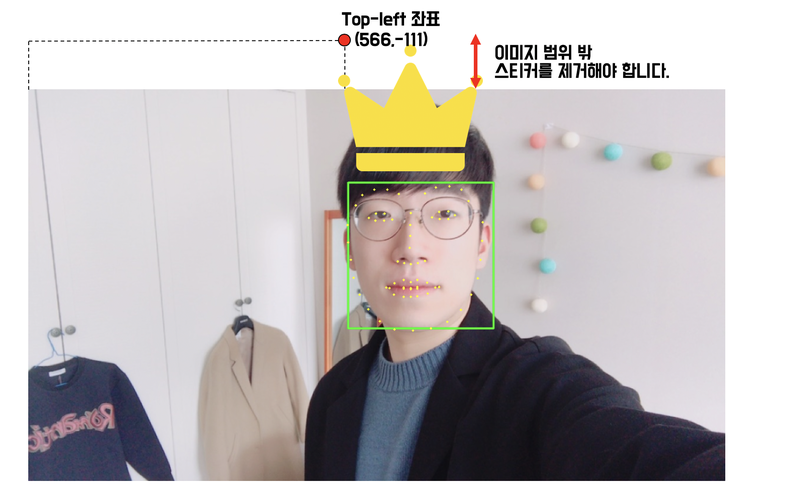

opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

In [13]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(69, 156, 3)


-y 크기만큼 스티커를 crop 합니다.


top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

In [14]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,0)


원본 이미지에 스티커를 적용합니다.

In [15]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

결과 이미지를 출력하면,

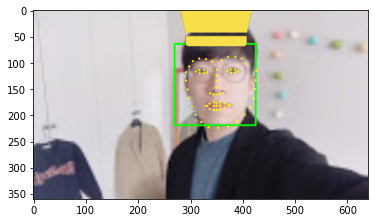

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

짠~ 스티커 기본 기능이 완성 되었습니다.

bounding box와 landmark를 제거하고 최종 결과만 출력해 봅시다. img_show 대신, 지금까지 아껴 두었던 img_rgb를 활용할 것입니다.

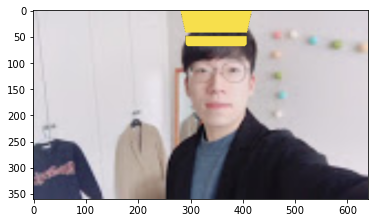

In [17]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

여러분이 사용하고 있는 어플의 초기 버전을 완성했습니다.

### 10-6. 프로젝트: 고양이 수염 스티커 만들기

오늘 배운 내용을 이용해서 여러분 만의 스티커를 만들고 적용해보겠습니다.

##### Step 1. 스티커 구하기 or 만들기
___
스티커를 만들거나 구해야합니다. PPT, 포토샵 등을 이용해서 직접 만드셔도 좋습니다. 보다 간단한 방법은 픽토그램 아이콘을 이용하면 쉽게 만들 수 있습니다.

고양이는 사랑스럽기 때문에 고양이 수염 스티커를 붙여보겠습니다.

마침 flaticon 사이트에 고양이 수염 이미지가 공개되어 있습니다.

* [고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)

(1) 고양이 수염 이미지를 다운로드 받아주세요.  
(2) 여러분의 셀카 이미지도 촬영해 주세요.  

##### Step 2. 얼굴 검출 & 랜드마크 검출 하기
___
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

##### Step 3. 스티커 적용 위치 확인하기
___
고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.  
볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?  

[hint] 2, 36, 48, 30 번 인덱스를 이용

##### Step 4. 스티커 적용하기
___
(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.  
(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.

[hint] opencv 의 cv2.addWeighted() 를 참고하세요.


##### Step 5. 문제점 찾아보기
___
(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.  
(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

>오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.
* 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
* 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
* 실행 속도가 중요할까요?
* 스티커앱을 만들 때 정확도가 얼마나 중요할까요?